## Parameter Estimation of Lotka-Volterra Equation using DiffEqBayes.jl

In [1]:
using Suppressor
@suppress_err using DiffEqBayes

[Turing]: AD chunk size is set as 40


In [2]:
using Distributions
using DifferentialEquations
using Plots
using DiffEqMonteCarlo,ContinuousTransformations

In [3]:
gr(fmt=:png)

Plots.GRBackend()

#### Initializing the problem

In [4]:
f = @ode_def_nohes LotkaVolterraTest begin
    dx = a*x - b*x*y
    dy = -c*y + d*x*y
end a b c d

(::LotkaVolterraTest) (generic function with 9 methods)

In [5]:
u0 = [1.0,1.0]
tspan = (0.0,10.0)
p = [1.5,1.0,3.0,1,0]

5-element Array{Float64,1}:
 1.5
 1.0
 3.0
 1.0
 0.0

In [6]:
prob = ODEProblem(f,u0,tspan,p)
@time sol = solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 34-element Array{Float64,1}:
  0.0      
  0.0776085
  0.232645 
  0.429118 
  0.679082 
  0.944406 
  1.26746  
  1.61929  
  1.98697  
  2.26409  
  2.51254  
  2.74682  
  3.038    
  ⋮        
  6.45576  
  6.7805   
  7.17104  
  7.58486  
  7.97806  
  8.48316  
  8.71924  
  8.9492   
  9.20018  
  9.43802  
  9.7118   
 10.0      
u: 34-element Array{Array{Float64,1},1}:
 [1.0, 1.0]         
 [1.04549, 0.857668]
 [1.17587, 0.63946] 
 [1.41968, 0.456996]
 [1.87672, 0.324733]
 [2.58825, 0.263362]
 [3.86071, 0.279446]
 [5.75081, 0.522006]
 [6.81498, 1.91778] 
 [4.39301, 4.19467] 
 [2.10088, 4.31696] 
 [1.24228, 3.10738] 
 [0.958273, 1.76616]
 ⋮                  
 [0.952206, 1.43835]
 [1.10046, 0.752663]
 [1.59911, 0.390319]
 [2.61424, 0.26417] 
 [4.24104, 0.305121]
 [6.79111, 1.1345]  
 [6.26541, 2.74165] 
 [3.78084, 4.43114] 
 [1.81645, 4.06409] 
 [1.14652, 2.79124] 
 [0.9558, 1.6236]   
 [1.03376, 0.90

#### We take the solution data obtained and add noise to it to obtain data for using in the Bayesian Inference of the parameters

In [7]:
t = collect(linspace(1,10,10))
sig = 0.49
data = convert(Array, VectorOfArray([(sol(t[i]) + sig*randn(2)) for i in 1:length(t)]))

2×10 Array{Float64,2}:
 2.53025   8.29929  1.0123  2.2121    5.7422  …   4.65793   3.4161  0.583169
 0.734816  1.45889  1.8125  0.925951  1.1567     -0.381489  4.5278  1.74832 

  3.761541 seconds (3.42 M allocations: 193.193 MiB, 5.55% gc time)


#### Plots of the actual data and generated data

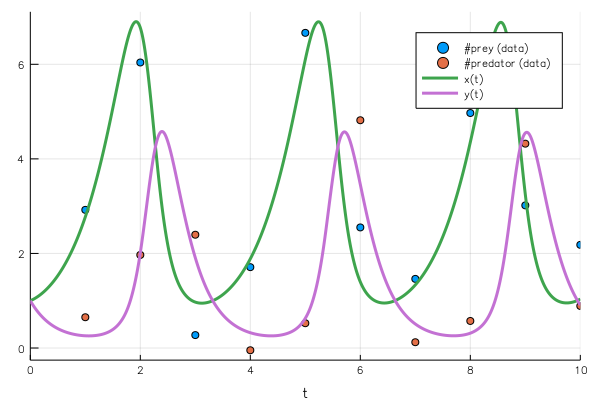

In [8]:
scatter(t, data[1,:], lab="#prey (data)")
scatter!(t, data[2,:], lab="#predator (data)")
plot!(sol)

In [8]:
priors = [Truncated(Normal(1.5,0.5),0.5,2.5),Truncated(Normal(1.0,0.5),0,2),Truncated(Normal(3.0,0.5),1,4),Truncated(Normal(1.0,0.5),0,2)]

4-element Array{Distributions.Truncated{Distributions.Normal{Float64},Distributions.Continuous},1}:
 Truncated(Distributions.Normal{Float64}(μ=1.5, σ=0.5), range=(0.5, 2.5))
 Truncated(Distributions.Normal{Float64}(μ=1.0, σ=0.5), range=(0.0, 2.0))
 Truncated(Distributions.Normal{Float64}(μ=3.0, σ=0.5), range=(1.0, 4.0))
 Truncated(Distributions.Normal{Float64}(μ=1.0, σ=0.5), range=(0.0, 2.0))

### Parameter estimation with Stan.jl backend

The solution converges for tolerance values lower than 1e-3, lower tolerance leads to better accuracy in result but is accompanied by longer warmup and sampling time, truncated normal priors are used for preventing Stan from stepping into negative values. 

In [10]:
@time bayesian_result_stan = stan_inference(prob,t,data,priors;num_samples=100,num_warmup=1000,reltol=1e-5,abstol=1e-5,vars =(StanODEData(),InverseGamma(3,2)))


File /Users/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.stan will be updated.



--- Translating Stan model to C++ code ---
bin/stanc  /Users/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.stan --o=/Users/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.hpp
Model name=parameter_estimation_model_model
Input file=/Users/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.stan
Output file=/Users/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.hpp

--- Linking C++ model ---
c++ -Wall -I . -isystem stan/lib/stan_math/lib/eigen_3.3.3 -isystem stan/lib/stan_math/lib/boost_1.64.0 -isystem stan/lib/stan_math/lib/cvodes_2.9.0/include -std=c++1y -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DBOOST_PHOENIX_NO_VARIADIC_EXPRESSION -Wno-unused-function -Wno-uninitialized -I src -isystem stan/src -isystem stan/lib/stan_math

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Scale parameter[1] is 0, but must be > 0!  (in '/Users/vaibhav/DiffEqBenchmarks.jl/ParameterEstimation/tmp/parameter_estimation_model.stan' at line 37)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.




Calling /Users/vaibhav/Downloads/cmdstan-2.17.1/bin/stansummary to infer across chains.

Inference for Stan model: parameter_estimation_model_model
4 chains: each with iter=(100,100,100,100); warmup=(0,0,0,0); thin=(1,1,1,1); 400 iterations saved.

Warmup took (30, 29, 29, 30) seconds, 2.0 minutes total
Sampling took (3.8, 2.8, 2.8, 3.3) seconds, 13 seconds total

                 Mean     MCSE  StdDev     5%    50%    95%  N_Eff  N_Eff/s    R_hat
lp__              1.2  1.7e-01     2.0   -3.0    1.5    3.7    149       12  1.0e+00
accept_stat__    0.94  4.8e-03   0.095   0.78   0.98   1.00    400       32  1.0e+00
stepsize__      0.079  7.8e-03   0.011  0.067  0.087  0.093    2.0     0.16  9.7e+14
treedepth__       4.9  9.5e-02    0.91    3.0    5.0    6.0     91      7.2  1.0e+00
n_leapfrog__       44  2.9e+00      24    7.0     31     79     69      5.5  1.0e+00
divergent__      0.00  0.0e+00    0.00   0.00   0.00   0.00    400       32      nan
energy__          2.0  2.4e-01     2.

DiffEqBayes.StanModel{Int64,Mamba.Chains}(0, Object of type "Mamba.Chains"

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

[-1.54884 0.998434 … 3.48139 1.14166; -5.7215 0.651332 … 3.14474 1.01851; … ; 3.61887 0.998819 … 3.20369 1.13683; 1.74937 0.96871 … 3.40078 1.1687]

[1.72469 0.986033 … 3.37692 1.17227; 3.81316 0.928541 … 3.01146 1.04844; … ; 3.33993 0.984649 … 2.90855 1.0123; 2.45548 0.993997 … 2.89317 0.992823]

[-6.25643 0.909749 … 2.72068 0.99315; -5.23264 0.693901 … 2.80356 0.975011; … ; 2.85238 0.998264 … 2.82348 1.00658; -0.366804 0.937386 … 3.35778 1.15269]

[1.64656 0.937415 … 3.17562 1.08291; -3.19688 0.44381 … 3.0524 1.11554; … ; 0.71568 0.96236 … 2.91033 1.05848; 2.8842 0.997587 … 3.00654 1.06369])

In [11]:
Mamba.describe(bayesian_result_stan.chain_results)

Iterations = 1:100
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 100

Empirical Posterior Estimates:
                  Mean         SD        Naive SE       MCSE         ESS    
         lp__  1.15169956  2.037955726 0.1018977863 0.1415212364 100.0000000
accept_stat__  0.94380732  0.095457271 0.0047728636 0.0108986503  76.7136409
   stepsize__  0.07907270  0.011002564 0.0005501282 0.0063443880   3.0075188
  treedepth__  4.87750000  0.908050185 0.0454025092 0.1510173831  36.1547882
 n_leapfrog__ 43.96000000 24.314530449 1.2157265225 4.2050128815  33.4346755
  divergent__  0.00000000  0.000000000 0.0000000000 0.0000000000         NaN
     energy__  2.01718402  2.704888956 0.1352444478 0.1556248195 100.0000000
     sigma1.1  0.44923953  0.128078809 0.0064039405 0.0146322930  76.6178185
     sigma1.2  0.45337759  0.129022216 0.0064511108 0.0052166661 100.0000000
       theta1  1.45558565  0.076306163 0.0038153081 0.0025264970 100.0000000
       theta2  0.93306351  0.069184071 

Plots of the chains generated to show convergence. 

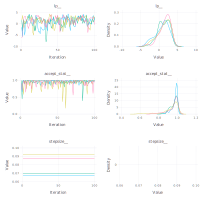

Press ENTER to draw next plot


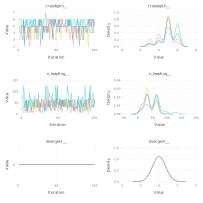

Press ENTER to draw next plot


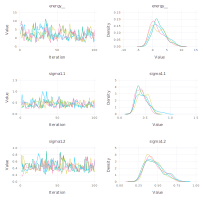

Press ENTER to draw next plot


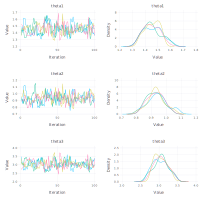

Press ENTER to draw next plot


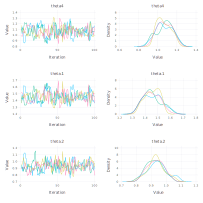

Press ENTER to draw next plot


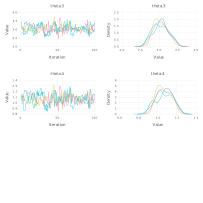

In [16]:
plot_chain(bayesian_result_stan)

### Parameter estimation with Turing.jl backend

In [9]:
Turing.turnprogress(false)
@time bayesian_result_turing1 = turing_inference(prob,Tsit5(),t,data,priors;delta=0.1,num_samples=5000)

[Turing]: global PROGRESS is set as false
[Turing] looking for good initial eps...
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.NUTS] found initial ϵ: 0.1
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerica

Object of type "Turing.Chain"

Iterations = 1:5000
Thinning interval = 1
Chains = 1
Samples per chain = 5000

[1.71108 14.9313 … -83.8996 0.1; 1.70609 15.2719 … -82.6258 0.833753; … ; 1.22505 1.39474 … -42.737 0.0650402; 1.26806 1.65426 … -43.134 0.0650402]

In [17]:
Mamba.describe(bayesian_result_turing1)

Iterations = 1:5000
Thinning interval = 1
Chains = 1
Samples per chain = 5000

Empirical Posterior Estimates:
             Mean         SD       Naive SE       MCSE         ESS   
 theta4   1.095904623 0.17752729 0.0025106150 0.0123465880  206.74563
      σ   1.695113294 0.53263771 0.0075326348 0.0298868888  317.61603
 theta2   1.102786410 0.17751228 0.0025104027 0.0102896083  297.61795
 theta1   1.996938730 0.16206332 0.0022919215 0.0128308688  159.53551
 lf_num   0.001600000 0.11313708 0.0016000000 0.0016000000 5000.00000
elapsed   0.052870190 0.20838284 0.0029469784 0.0030509261 4665.09556
 theta3   2.840674396 0.26546966 0.0037543079 0.0207726531  163.32244
     lp -43.745096343 2.21874794 0.0313778342 0.1666995037  177.15251
 lf_eps   0.084267877 0.10086230 0.0014264084 0.0069603939  209.98590

Quantiles:
             2.5%         25.0%         50.0%         75.0%         97.5%   
 theta4   0.796979135   0.969896776   1.080447975   1.205880098   1.49466947
      σ   1.204908997   

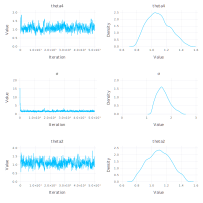

Press ENTER to draw next plot


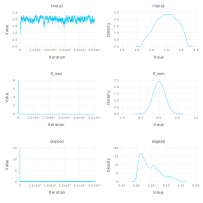

Press ENTER to draw next plot


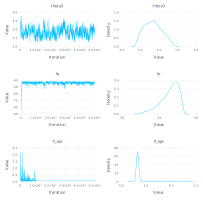

In [18]:
plot_chain(bayesian_result_turing1)

In [12]:
Turing.turnprogress(false)
@time bayesian_result_turing2 = turing_inference(prob,Tsit5(),t,data,priors;delta=0.15,num_samples=5000)

[Turing]: global PROGRESS is set as false
[Turing] looking for good initial eps...
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.NUTS] found initial ϵ: 0.003125
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Num

Excessive output truncated after 524517 bytes.

[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has been found in gradients.
 verifygrad(::Array{Float64,1}) at ad.jl:87
[Turing.WARNING]: Numerical error has

Object of type "Turing.Chain"

Iterations = 1:5000
Thinning interval = 1
Chains = 1
Samples per chain = 5000

[1.28249 8.5579 … -73.8314 0.003125; 1.28249 8.5579 … -73.9235 0.0237906; … ; 1.24637 2.63037 … -52.9979 0.160863; 1.24637 2.63037 … -52.9979 0.160863]

In [19]:
Mamba.describe(bayesian_result_turing2)

Iterations = 1:5000
Thinning interval = 1
Chains = 1
Samples per chain = 5000

Empirical Posterior Estimates:
             Mean          SD       Naive SE       MCSE         ESS    
 theta4   1.181010390 0.099076346 0.0014011511 0.0114265203   75.181670
      σ   2.383881504 0.716475480 0.0101324934 0.0686937569  108.784777
 theta2   1.433134538 0.205348361 0.0029040644 0.0254011260   65.354658
 theta1   2.263989629 0.095482963 0.0013503330 0.0117424980   66.119687
 lf_num   0.001400000 0.098994949 0.0014000000 0.0014000000 5000.000000
elapsed   0.013638192 0.018058806 0.0002553901 0.0010628458  288.693871
 theta3   3.655947647 0.164592055 0.0023276832 0.0209408845   61.777124
     lp -54.597800284 2.259219022 0.0319501818 0.2326078559   94.333927
 lf_eps   0.143004270 0.057578891 0.0008142885 0.0056513081  103.807474

Quantiles:
             2.5%         25.0%         50.0%         75.0%         97.5%    
 theta4   1.011596838   1.101076590   1.176086921   1.254222991   1.375937115
  

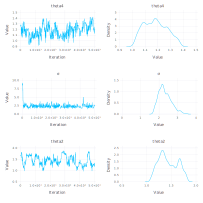

Press ENTER to draw next plot


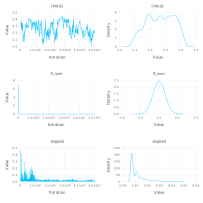

Press ENTER to draw next plot


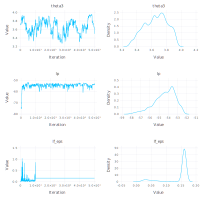

In [20]:
plot_chain(bayesian_result_turing2)

### Parameter estimation using DynamicHMC.jl backend.

In [22]:
global bayesian_result_dynamic
@suppress_err @time bayesian_result_dynamic = dynamichmc_inference(prob,Tsit5(),t,data,priors, [bridge(ℝ, ℝ⁺, ),bridge(ℝ, ℝ⁺, ),bridge(ℝ, ℝ⁺, ),bridge(ℝ, ℝ⁺, )])

(([1.53014, 1.52936, 1.52796, 1.53012, 1.52966, 1.52925, 1.52948, 1.52941, 1.52916, 1.53108  …  1.53081, 1.53069, 1.53069, 1.53074, 1.53012, 1.52987, 1.53002, 1.52931, 1.53013, 1.53028], [1.12245, 1.12207, 1.11866, 1.12137, 1.12038, 1.11981, 1.11968, 1.11935, 1.11851, 1.12135  …  1.12276, 1.12159, 1.12159, 1.12142, 1.12048, 1.12015, 1.11962, 1.11893, 1.12132, 1.12152], [3.03231, 3.0329, 3.03704, 3.0318, 3.03191, 3.03485, 3.03391, 3.03289, 3.03409, 3.02936  …  3.02792, 3.02966, 3.02966, 3.02926, 3.02993, 3.03096, 3.02994, 3.03263, 3.03089, 3.02998], [0.935357, 0.936323, 0.937869, 0.934917, 0.935449, 0.936326, 0.935623, 0.935553, 0.935779, 0.933788  …  0.934052, 0.934419, 0.934419, 0.934343, 0.934744, 0.935269, 0.934692, 0.936109, 0.935386, 0.934945]), DynamicHMC.NUTS_Transition{Array{Float64,1},Float64}[DynamicHMC.NUTS_Transition{Array{Float64,1},Float64}([0.425358, 0.115511, 1.10933, -0.0668272], -26294.5, 2, DoubledTurn, 0.989428, 3), DynamicHMC.NUTS_Transition{Array{Float64,1},Float6

100.814798 seconds (89.05 M allocations: 11.596 GiB, 4.17% gc time)


In [23]:
DynamicHMC.NUTS_statistics(bayesian_result_dynamic[2]),bayesian_result_dynamic[3],mean(bayesian_result_dynamic[1][1]),mean(bayesian_result_dynamic[1][2]),mean(bayesian_result_dynamic[1][3]),mean(bayesian_result_dynamic[1][4])

(Hamiltonian Monte Carlo sample of length 1000
  acceptance rate mean: 0.73, min/25%/median/75%/max: 0.02 0.4 0.91 0.98 1.0
  termination: AdjacentTurn => 20% DoubledTurn => 80%
  depth: 1 => 1% 2 => 37% 3 => 62%
, NUTS sampler in 4 dimensions
  stepsize (ϵ) ≈ 0.463
  maximum depth = 5
  Gaussian kinetic energy, √diag(M⁻¹): [0.000725909, 0.00190001, 0.000935244, 0.00136266]
, 1.5294158543465817, 1.1201758257744867, 3.0332225463356806, 0.936007487992528)

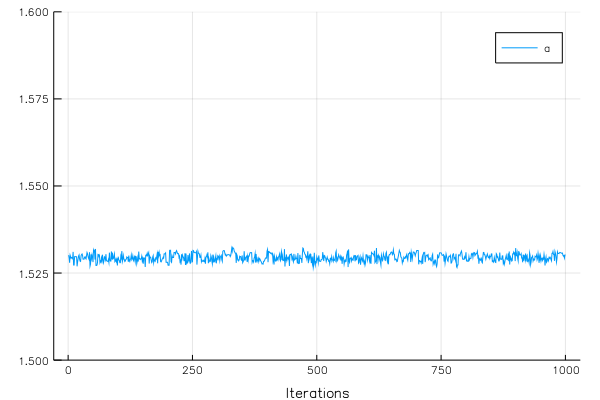

In [30]:
plot(bayesian_result_dynamic[1][1], label="a", xlab="Iterations",ylims=(1.5,1.6))

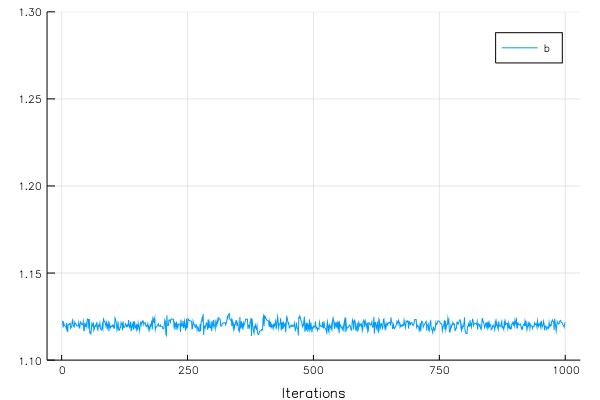

In [32]:
plot(bayesian_result_dynamic[1][2], label="b", xlab="Iterations",ylims=(1.1,1.3))

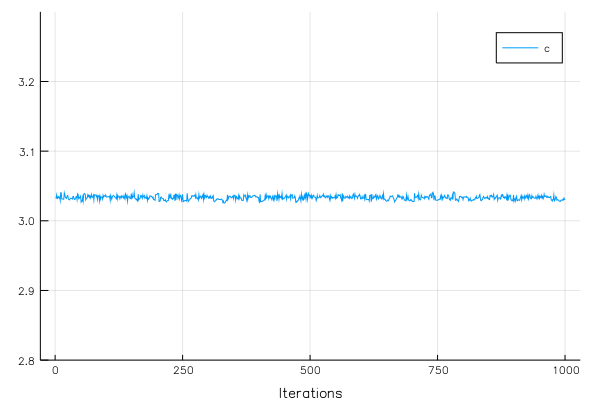

In [33]:
plot(bayesian_result_dynamic[1][3], label="c", xlab="Iterations",ylims=(2.8,3.3))

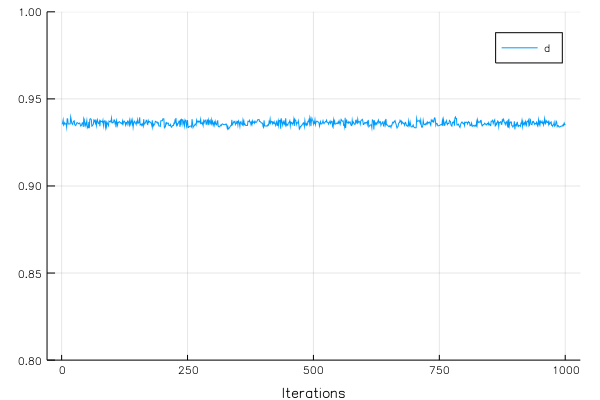

In [35]:
plot(bayesian_result_dynamic[1][4], label="d", xlab="Iterations",ylims=(0.8,1.0))